# Raw Data Reconstruction#

This code are used to reconstruct the spectrum based on the feature map extracted from the last script. 

In [ ]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.optimizers import Adam
from keras.models import Sequential
from matplotlib import pyplot as plt
from keras.callbacks import ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.layers import Dropout, Activation, Dense, Flatten
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from numpy import expand_dims

# Data Loading and Index Created 
# Train Test Split #

In [2]:
Fea1=pd.read_csv('FeatureMap1.csv').T
Fea2=pd.read_csv('FeatureMap2.csv')
Val=pd.read_csv('Nox_PeakRemoved.csv').T
New=pd.read_csv('Predict_tem.csv')
num=3
Tem=[300,600,800]
for k in range(3):
    for j in range(num):
        Tem.insert(j+1,(Tem[j]+Tem[j+1])/2)
for k in range(3):
    for j in range(num):
        Tem.insert(-j-1,(Tem[-j-1]+Tem[-j-2])/2)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(Fea1.values, Val.values, test_size=0.15, random_state=13)
display(y_train.shape,X_train.shape)

(17, 541)

(17, 64)

# New Net Work Build for Training #

- The input will be 64 data point (which is the feature map extracting from the last script)
- The put put will be 514 data point of the spectrum

In [4]:
model = Sequential()
activation = 'relu'
model.add(Dense(1024, input_dim = X_train.shape[1],activation=activation))
model.add(Dense(1024, activation=activation))
model.add(Dense(2048, activation=activation))
model.add(Dense(1024, activation=activation))
model.add(Dense(541, activation='linear'))
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              66560     
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_3 (Dense)              (None, 2048)              2099200   
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_5 (Dense)              (None, 541)               554525    
Total params: 5,868,061
Trainable params: 5,868,061
Non-trainable params: 0
_________________________________________________________________
None


# Model Training #

In [36]:
checkpoint_name = '4Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]
model.fit(X_train, y_train, epochs=1000, batch_size=512, validation_split = 0.2,validation_data=(X_test, y_test), shuffle = True,callbacks=callbacks_list)

Train on 17 samples, validate on 4 samples
Epoch 1/1000
17/17 [==============================] - 0s 587us/step - loss: 1.2766e-04 - mean_absolute_error: 1.2766e-04 - val_loss: 0.0015 - val_mean_absolute_error: 0.0015

Epoch 00001: val_loss improved from inf to 0.00146, saving model to 4Weights-001--0.00146.hdf5
Epoch 2/1000
17/17 [==============================] - 0s 528us/step - loss: 1.4480e-04 - mean_absolute_error: 1.4480e-04 - val_loss: 0.0014 - val_mean_absolute_error: 0.0014

Epoch 00002: val_loss improved from 0.00146 to 0.00142, saving model to 4Weights-002--0.00142.hdf5
Epoch 3/1000
17/17 [==============================] - 0s 528us/step - loss: 1.2543e-04 - mean_absolute_error: 1.2543e-04 - val_loss: 0.0014 - val_mean_absolute_error: 0.0014

Epoch 00003: val_loss improved from 0.00142 to 0.00140, saving model to 4Weights-003--0.00140.hdf5
Epoch 4/1000
17/17 [==============================] - 0s 528us/step - loss: 1.0861e-04 - mean_absolute_error: 1.0861e-04 - val_loss: 0.0015

# Weight Loading and Accuracy Test #

In [14]:
weights='4Weights-079--0.00058.hdf5'
model.load_weights(weights)
fea=model.predict(New)

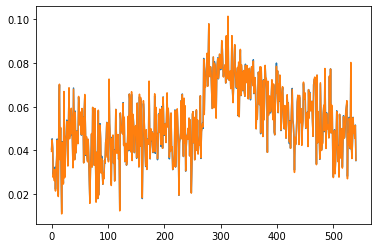

In [38]:
plt.plot(y_test[0])
plt.plot(fea[0])

In [16]:
nf=(fea[0]-0.045)/1000
nt=(y_test[0]-0.045)/1000
dif=nt-nf
plt.plot(nf,label='predicted')
plt.plot(nt,label='Raw')
plt.plot(dif,label='error')
plt.legend()

ValueError: operands could not be broadcast together with shapes (6,) (541,) 

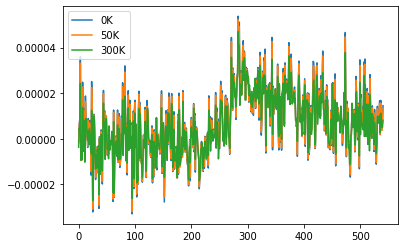

In [20]:
nf=(fea[0]-0.045)/1000
nf1=(fea[1]-0.045)/1000
nt=(y_test[2]-0.045)/1000
plt.plot(nf,label='0K')
plt.plot(nf1,label='50K')
plt.plot(nt,label='300K')
plt.legend()

**Standby, The probelm:
Because the interpolation tell us when T=0K, the feature map will be negative, thus, it is necessary to do several things**
- Try to add some value to biases to raise the intercept
- Take the predicted spectrum 200K and 250K back to training (problem because the 200/250K may contain some error, take it back may cause greater error)

In [60]:
T250=(fea[5]-0.045)/1000
T200=(fea[4]-0.045)/1000
Minus={}
Minus['200K']=T200
Minus['250K']=T250
Mindf=DataFrame(Minus)
Newdf=pd.read_csv('Nox_PeakRemoved.csv')

In [66]:
pd.concat([Mindf,Newdf],axis=1).to_csv('Extended.csv')

In [12]:
New=pd.read_csv('Predict_tem.csv').T

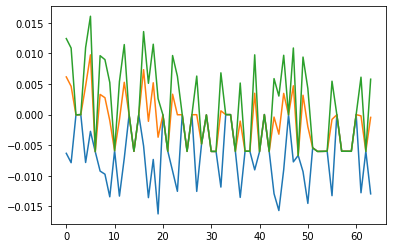

In [30]:
plt.plot(New.iloc[0:1].values[0])
plt.plot(New.iloc[4:5].values[0])
plt.plot(Fea1.iloc[0:1].values[0])

In [39]:
Whole=pd.concat([New,Fea1],axis=0)

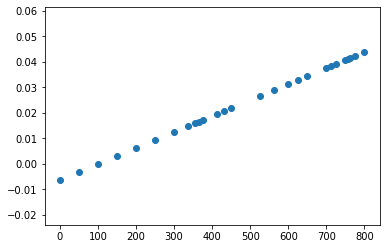

In [58]:
Tem1=[300,600,800]
for k in range(3):
    for j in range(num):
        Tem1.insert(j+1,(Tem1[j]+Tem1[j+1])/2)
for k in range(3):
    for j in range(num):
        Tem1.insert(-j-1,(Tem1[-j-1]+Tem1[-j-2])/2)
Tem1.insert(0,0)
Tem1.insert(1,50)
Tem1.insert(2,100)
Tem1.insert(3,150)
Tem1.insert(4,200)
Tem1.insert(5,250)
plt.scatter(Tem1,Whole.iloc[:,0:1].values.flatten())

In [ ]:
fig= plt.figure(figsize=(18,12))
for i in range(15,17):
    plt.plot(Fea1.iloc[i-1:i].values[0],label=Tem[i-1])
plt.plot(X_train[4],label='Target')
plt.legend()